# Walmart Sales Forecasting Project 📊

## Overview
This notebook demonstrates a comprehensive machine learning pipeline for forecasting Walmart sales data. The project includes:

- **Data Loading & Quality Assessment**: Loading multiple datasets and checking data quality
- **Exploratory Data Analysis**: Visualizing patterns and relationships in the data
- **Data Preprocessing**: Cleaning, feature engineering, and preparation
- **Model Training & Evaluation**: Testing multiple algorithms and comparing performance
- **Feature Importance Analysis**: Understanding which factors drive sales predictions

## Dataset Description
The Walmart dataset contains:
- **Training Data**: Historical weekly sales data for 45 stores across 99 departments
- **Store Information**: Store type and size details
- **Features Data**: Economic indicators (CPI, unemployment, fuel prices) and holiday information
- **Test Data**: Data for making future predictions

Let's start by importing the necessary libraries and setting up our environment.

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import os
import time

# Suppress warnings and set plotting style
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
SEED = 2024
np.random.seed(SEED)

print("✅ All libraries imported successfully!")

In [ ]:
# Setup Project Directories
# Create necessary directories for organizing our project files
DATA_DIR = 'data/raw'
PROCESSED_DIR = 'data/processed'
MODEL_DIR = 'models'

# Create directories if they don't exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("📁 Project directories set up successfully!")
print(f"Raw data directory: {DATA_DIR}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Model directory: {MODEL_DIR}")

# 1. Data Loading 📥

In this section, we'll load all the required datasets:
- **stores.csv**: Information about each store (type, size)
- **train.csv**: Historical sales data for training
- **features.csv**: Additional features like economic indicators
- **test.csv**: Data for making predictions

In [ ]:
# Load all required datasets from Kaggle
print("Loading datasets...")

# Load store information
df_store = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')
print(f"✅ Stores data loaded: {df_store.shape}")

# Load training data with historical sales
df_train = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv') 
print(f"✅ Training data loaded: {df_train.shape}")

# Load features data (economic indicators, holidays)
df_features = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')
print(f"✅ Features data loaded: {df_features.shape}")

# Load test data for predictions
df_test = pd.read_csv("/kaggle/input/walmart-sales-forecast/test.csv")
print(f"✅ Test data loaded: {df_test.shape}")

print("\n🎉 All datasets loaded successfully!")

# 2. Initial Data Exploration 🔍

Let's examine the structure and content of each dataset to understand what we're working with.

In [ ]:
# Preview store data
print("🏪 Store Information Dataset:")
print("Contains store details including type (A, B, C) and size")
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
# Preview features data
print("📊 Economic Features Dataset:")
print("Contains economic indicators: Temperature, Fuel_Price, CPI, Unemployment, Holiday flags, and Markdowns")
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# Preview training data
print("🎯 Training Dataset:")
print("Contains our target variable 'Weekly_Sales' along with Store, Dept, Date, and IsHoliday")
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
# Preview test data
print("🔮 Test Dataset:")
print("Similar structure to training data but without Weekly_Sales (our prediction target)")
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


# 3. Data Integration & Preparation 🔗

Now we'll merge all datasets into a single comprehensive dataset for analysis.

In [ ]:
# Merge all datasets into a comprehensive dataset
print("🔗 Merging datasets...")

# Step 1: Merge training data with features data (on Store and Date)
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner')
print(f"After merging train + features: {df.shape}")

# Step 2: Merge with store information (on Store)
df = df.merge(df_store, on=['Store'], how='inner')
print(f"After merging with store info: {df.shape}")

print("✅ All datasets successfully merged!")
print(f"Final dataset contains {df.shape[0]} rows and {df.shape[1]} columns")

In [ ]:
# Sort data chronologically for time series analysis
# This is crucial for time series modeling and feature engineering
df = df.sort_values(['Store', 'Dept', 'Date'])
print("📅 Data sorted by Store, Department, and Date for temporal analysis")

In [ ]:
# Initial handling of markdown columns
# Fill missing markdown values with 0 (assuming no markdown when data is missing)
print("🧹 Handling missing Markdown values...")

for col in ['MarkDown1', 'MarkDown2', 'MarkDown3']:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        print(f"Filled {missing_count} missing values in {col} with 0")

print("✅ Markdown columns cleaned")

In [ ]:
# Preview the merged and cleaned dataset
print("👀 Preview of our integrated dataset:")
print("This now contains all features from stores, economic indicators, and sales data")
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,NaN,NaN,211.350143,8.106,False,A,151315


# 4. Data Quality Assessment 🔍

Let's perform a comprehensive quality check to understand our data better and identify any issues.

In [ ]:
def data_quality_assessment(df):
    """
    Comprehensive data quality assessment for real-world datasets
    
    This function analyzes:
    - Dataset structure and size
    - Missing values and their patterns
    - Duplicate records
    - Date range coverage
    - Store and department distribution
    """
    print("\n" + "="*60)
    print("🔍 COMPREHENSIVE DATA QUALITY ASSESSMENT")
    print("="*60)
    
    # Basic dataset overview
    print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        print(f"📅 Date Range: {df['Date'].min()} to {df['Date'].max()}")
    
    if 'Store' in df.columns:
        print(f"🏪 Number of Stores: {df['Store'].nunique()}")
    
    if 'Dept' in df.columns:
        print(f"🏬 Number of Departments: {df['Dept'].nunique()}")
    
    # Missing values analysis
    print("\n📋 MISSING VALUES ANALYSIS:")
    print("-" * 40)
    missing_info = df.isnull().sum()
    missing_percent = (missing_info / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing_info,
        'Missing_Percent': missing_percent
    }).sort_values('Missing_Percent', ascending=False)
    
    missing_columns = missing_df[missing_df['Missing_Count'] > 0]
    if len(missing_columns) > 0:
        print(missing_columns)
    else:
        print("✅ No missing values found!")
    
    # Duplicate records check
    print(f"\n🔄 DUPLICATE RECORDS:")
    print("-" * 40)
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"⚠️  Found {duplicate_count} duplicate records ({duplicate_count/len(df)*100:.2f}%)")
    else:
        print("✅ No duplicate records found!")
    
    return df

In [ ]:
# Run comprehensive data quality assessment
print("Running data quality assessment...")
df = data_quality_assessment(df)


DATA QUALITY ASSESSMENT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10)

In [ ]:
# Display basic statistical summary
print("📈 DATASET STATISTICAL SUMMARY:")
print("=" * 50)
print("This shows distribution statistics for all numerical columns")
df.describe()

 Dataset Statics Descritption : 


,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [ ]:
# Convert Date column to datetime format for proper time series analysis
df['Date'] = pd.to_datetime(df['Date'])
print("📅 Date column converted to datetime format")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

In [ ]:
# Remove duplicate IsHoliday column created during merge
# The merge created IsHoliday_x and IsHoliday_y, we only need one
if 'IsHoliday_y' in df.columns:
    df.drop(['IsHoliday_y'], axis=1, inplace=True)
    print("🗑️  Removed duplicate IsHoliday_y column")

In [ ]:
# Rename the remaining IsHoliday column to remove the _x suffix
if 'IsHoliday_x' in df.columns:
    df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
    print("✏️  Renamed IsHoliday_x to IsHoliday")
    
print(f"Current columns: {list(df.columns)}")

In [ ]:
# Outlier Detection for Weekly Sales using IQR (Interquartile Range) method
print("🎯 OUTLIER DETECTION FOR WEEKLY SALES")
print("=" * 50)
print("Using IQR method: Q1 - 1.5*IQR to Q3 + 1.5*IQR")

Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]
outlier_percentage = len(outliers) / len(df) * 100

print(f"📊 Quartile 1 (Q1): ${Q1:,.2f}")
print(f"📊 Quartile 3 (Q3): ${Q3:,.2f}")
print(f"📊 IQR: ${IQR:,.2f}")
print(f"📊 Lower bound: ${lower_bound:,.2f}")
print(f"📊 Upper bound: ${upper_bound:,.2f}")
print(f"⚠️  Outliers detected: {len(outliers):,} ({outlier_percentage:.2f}%)")

# Note: These outliers might be legitimate high sales periods (e.g., Black Friday)
# We'll keep them for now but monitor their impact on model performance

Outliers detected: 35521 (8.43%)


In [ ]:
# Final dataset shape after initial cleaning
print("📏 Final dataset dimensions after initial cleaning:")
print(f"Shape: {df.shape}")
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")

(421570, 16)

# 5. Exploratory Data Analysis & Visualization 📊

In this section, we'll create visualizations to understand:
- Distribution of numerical variables
- Holiday vs non-holiday sales patterns  
- Economic indicators trends over time
- Store and department performance patterns
- Data availability and gaps

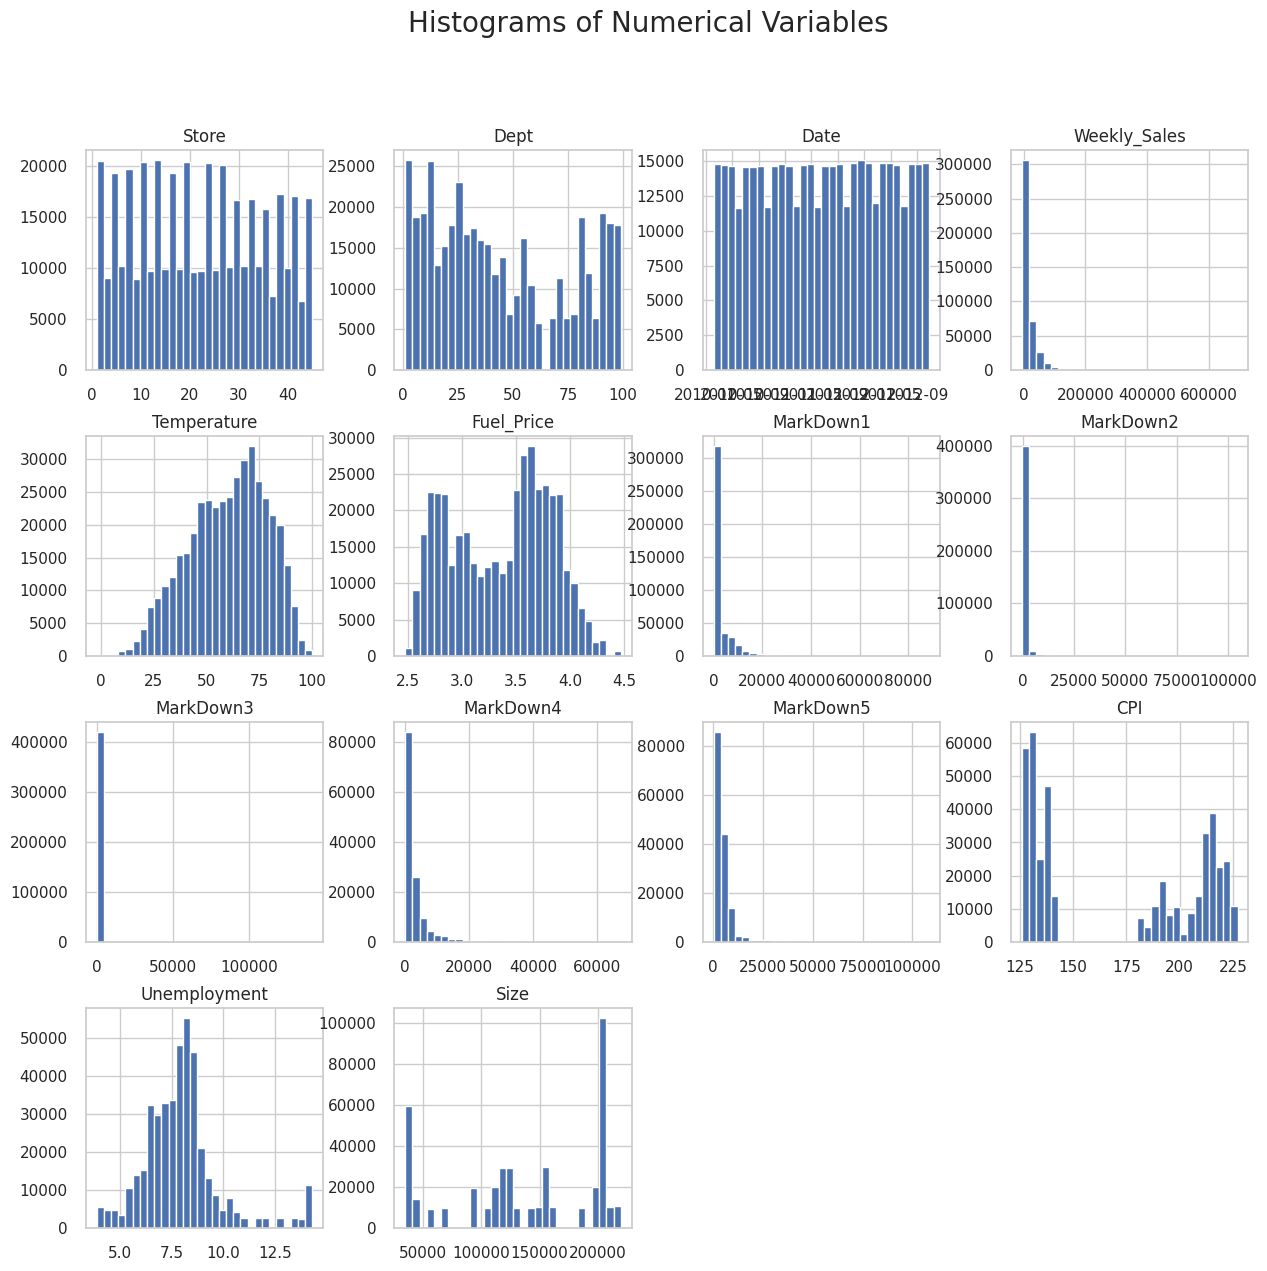

In [ ]:
# Distribution Analysis: Histograms for all numerical variables
print("📊 Analyzing distributions of numerical variables...")

# Set plotting style for better visualization
sns.set(style="whitegrid")

# Create histograms for all numerical columns
df.hist(bins=30, figsize=(15, 14))
plt.suptitle('Distribution of Numerical Variables', fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

print("💡 Key Observations:")
print("- Weekly_Sales: Shows right-skewed distribution with some very high sales periods")
print("- Temperature: Shows seasonal variation as expected")
print("- CPI & Unemployment: Show relatively normal distributions")
print("- Fuel_Price: Shows variation over time periods")
print("- Store Size: Shows distinct size categories")

<Axes: >

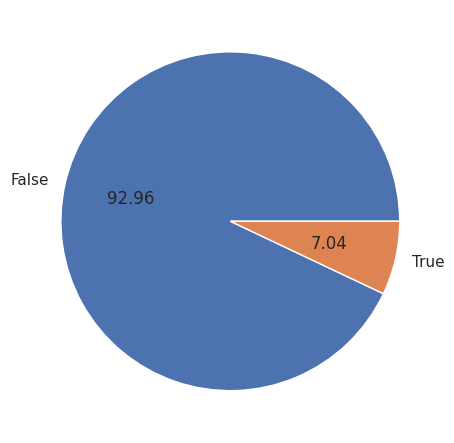

In [ ]:
# Holiday vs Non-Holiday Distribution
print("🎄 Holiday Distribution Analysis:")

plt.figure(figsize=(8, 6))
holiday_counts = df.groupby('IsHoliday').size()
plt.pie(holiday_counts.values, labels=['Non-Holiday', 'Holiday'], autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Holiday vs Non-Holiday Records')
plt.show()

print(f"📊 Non-Holiday records: {holiday_counts[False]:,}")
print(f"🎉 Holiday records: {holiday_counts[True]:,}")
print("💡 This shows the proportion of data from holiday vs regular weeks")

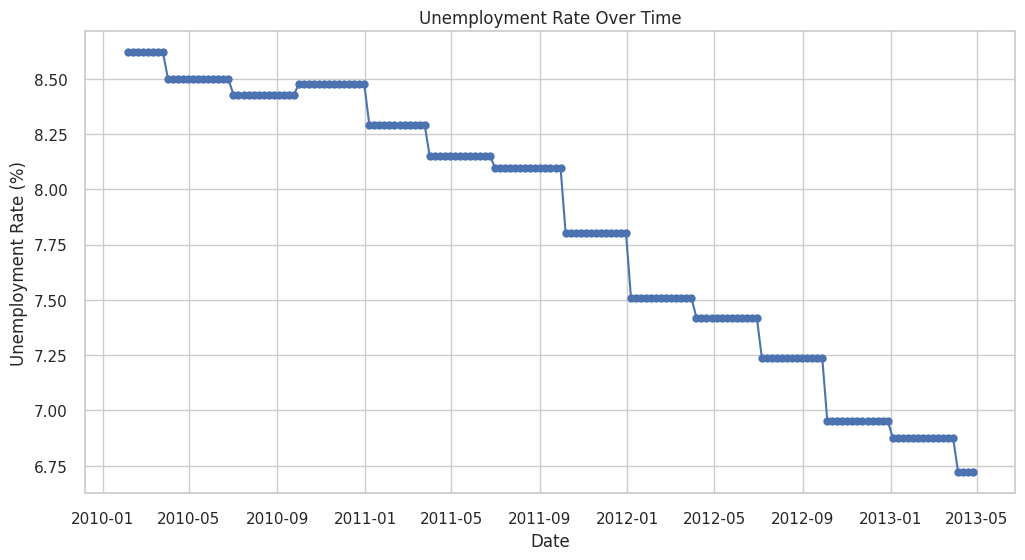

In [ ]:
# Economic Indicator 1: Unemployment Rate Trends
print("💼 Unemployment Rate Analysis Over Time")

# Convert date and group by date for average unemployment rate
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_grouped = df_features.groupby('Date')['Unemployment'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date'], df_grouped['Unemployment'], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.title('Average Unemployment Rate Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("💡 Key Insights:")
print("- Shows economic cycles and trends that may affect consumer spending")
print("- Higher unemployment typically correlates with lower consumer spending")
print("- Important feature for predicting sales variations")

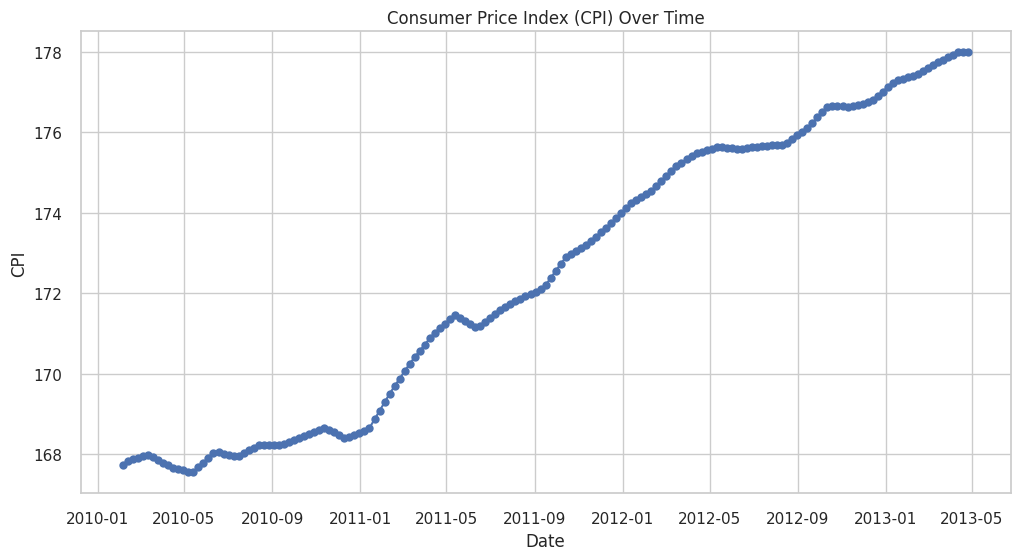

In [ ]:
# Economic Indicator 2: Consumer Price Index (CPI) Trends  
print("💰 Consumer Price Index (CPI) Analysis Over Time")

# Group by date and calculate average CPI
df_grouped_cpi = df_features.groupby('Date')['CPI'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_cpi['Date'], df_grouped_cpi['CPI'], marker='o', linestyle='-', 
         linewidth=2, markersize=4, color='green')
plt.title('Consumer Price Index (CPI) Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("💡 Key Insights:")
print("- CPI measures inflation and purchasing power changes")
print("- Rising CPI may indicate reduced purchasing power")
print("- Important economic indicator for sales forecasting")

In [25]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221


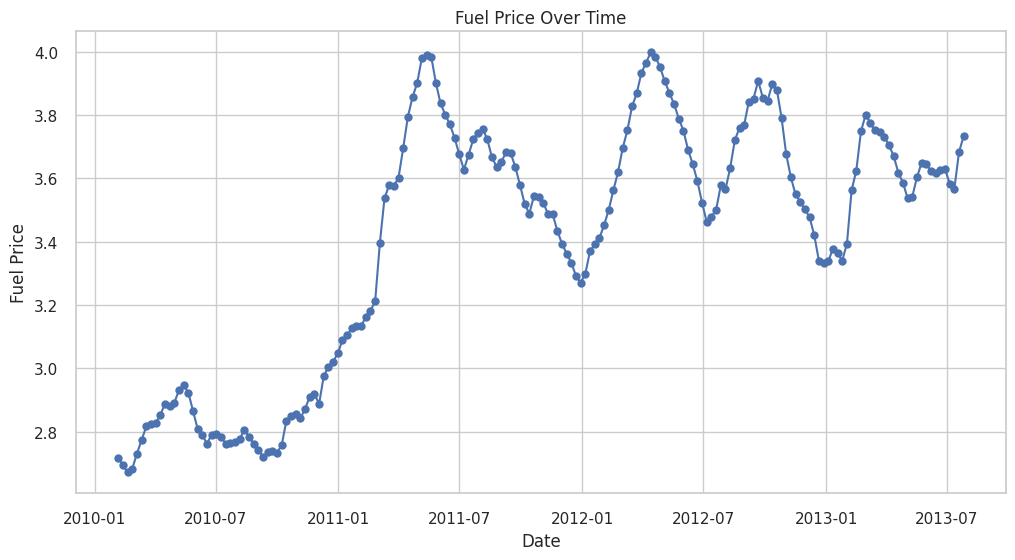

In [ ]:
# Economic Indicator 3: Fuel Price Trends
print("⛽ Fuel Price Analysis Over Time")

# Group by date and calculate average fuel price
df_grouped_fuel_price = df_features.groupby('Date')['Fuel_Price'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_fuel_price['Date'], df_grouped_fuel_price['Fuel_Price'], 
         marker='o', linestyle='-', linewidth=2, markersize=4, color='red')
plt.title('Average Fuel Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fuel Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("💡 Key Insights:")
print("- Fuel prices affect consumer disposable income")
print("- Higher fuel costs may reduce spending on retail goods")
print("- Shows volatility that could impact sales predictions")

In [ ]:
def plot_data_gaps_heatmap(df):
    """
    Visualize data availability across stores, departments, and time periods
    
    This heatmap helps identify:
    - Missing data patterns
    - Store-department combinations with incomplete data
    - Temporal gaps in data collection
    """
    print("🗓️ Creating data availability heatmap...")
    
    df_temp = df.copy()
    df_temp['Date'] = pd.to_datetime(df_temp['Date'], errors='coerce')
    
    # Create presence indicator: 1 if record exists, 0 otherwise
    df_temp['Value'] = 1
    
    # Create pivot table: Store-Dept vs Date
    heatmap_data = df_temp.pivot_table(index=['Store', 'Dept'], 
                                      columns='Date', 
                                      values='Value', 
                                      fill_value=0)
    
    # Limit size for visualization if too large
    if heatmap_data.shape[0] > 100:
        heatmap_data = heatmap_data.head(100)
        print(f"⚠️  Showing top 100 Store-Dept combinations (out of {df_temp.groupby(['Store', 'Dept']).ngroups})")
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(heatmap_data, cmap='Blues', cbar=True, 
                cbar_kws={'label': 'Data Available'})
    plt.title("📅 Data Availability Heatmap (Store-Dept vs Date)", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Store - Department", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Data availability statistics
    total_possible = heatmap_data.shape[0] * heatmap_data.shape[1]
    available_data = heatmap_data.sum().sum()
    availability_rate = (available_data / total_possible) * 100
    
    print(f"📊 Data Availability Statistics:")
    print(f"   - Total possible data points: {total_possible:,}")
    print(f"   - Available data points: {available_data:,}")
    print(f"   - Availability rate: {availability_rate:.1f}%")

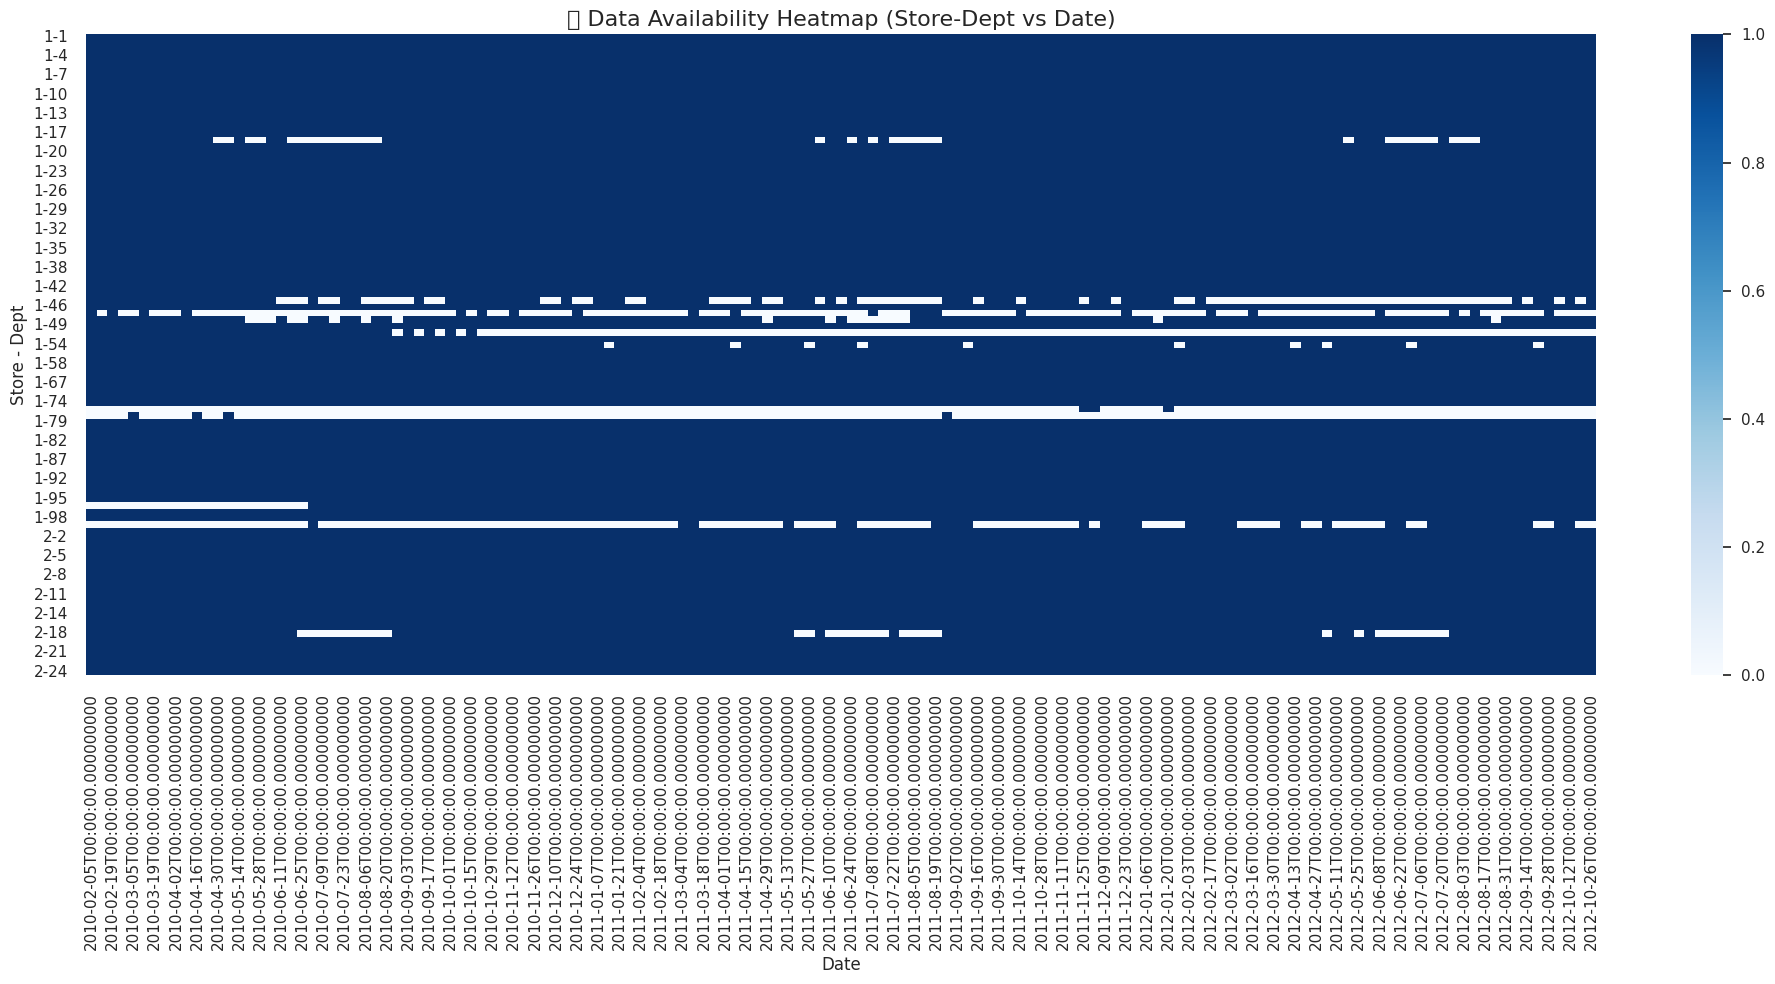

In [ ]:
# Visualize data availability patterns
print("📊 Analyzing data coverage across stores, departments, and time periods...")
plot_data_gaps_heatmap(df)

In [ ]:
def plot_store_dept_sales(df, store_id, dept_id):
    """
    Plot time series of weekly sales for a specific store-department combination
    
    This helps understand:
    - Seasonal patterns in sales
    - Trends over time
    - Volatility and outliers
    - Holiday effects
    """
    print(f"📈 Analyzing sales trends for Store {store_id}, Department {dept_id}")
    
    df_temp = df.copy()
    df_temp['Date'] = pd.to_datetime(df_temp['Date'], errors='coerce')
    
    # Filter for specific store and department
    subset = df_temp[(df_temp['Store'] == store_id) & (df_temp['Dept'] == dept_id)].sort_values('Date')
    
    if len(subset) == 0:
        print(f"⚠️  No data found for Store {store_id}, Department {dept_id}")
        return
    
    plt.figure(figsize=(15, 6))
    plt.plot(subset['Date'], subset['Weekly_Sales'], marker='o', linestyle='-', 
             linewidth=2, markersize=4, alpha=0.8)
    
    # Highlight holiday periods
    holiday_data = subset[subset['IsHoliday'] == True]
    if len(holiday_data) > 0:
        plt.scatter(holiday_data['Date'], holiday_data['Weekly_Sales'], 
                   color='red', s=50, alpha=0.7, label='Holiday Weeks')
        plt.legend()
    
    plt.title(f"📈 Weekly Sales Over Time (Store {store_id}, Department {dept_id})", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Weekly Sales ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Sales statistics
    print(f"📊 Sales Statistics:")
    print(f"   - Average weekly sales: ${subset['Weekly_Sales'].mean():,.2f}")
    print(f"   - Maximum weekly sales: ${subset['Weekly_Sales'].max():,.2f}")
    print(f"   - Minimum weekly sales: ${subset['Weekly_Sales'].min():,.2f}")
    print(f"   - Standard deviation: ${subset['Weekly_Sales'].std():,.2f}")

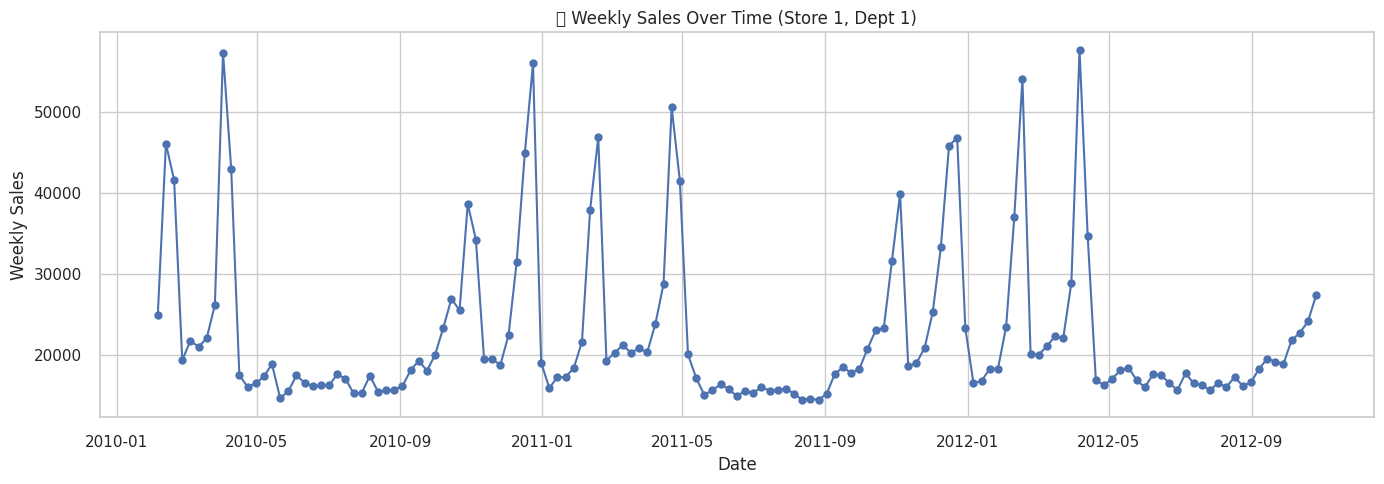

In [ ]:
# Example: Time series analysis for Store 1, Department 1
print("📊 Example Time Series Analysis:")
print("Looking at sales patterns for a specific store-department combination")
plot_store_dept_sales(df, store_id=1, dept_id=1)

# 6. Data Preprocessing & Feature Engineering 🔧

In this section we'll:
- Handle remaining missing values
- Clean markdown columns  
- Create new features (date components)
- Encode categorical variables
- Prepare data for machine learning models

In [ ]:
# Handle missing values in economic indicators
print("🧹 Handling Missing Values in Economic Indicators:")
print("=" * 55)

# Fill CPI missing values with median (stable economic indicator)
if df['CPI'].isnull().sum() > 0:
    cpi_missing = df['CPI'].isnull().sum()
    df['CPI'].fillna(df['CPI'].median(), inplace=True)
    print(f"✅ Filled {cpi_missing} missing CPI values with median: {df['CPI'].median():.2f}")

# Fill Unemployment missing values with median
if df['Unemployment'].isnull().sum() > 0:
    unemployment_missing = df['Unemployment'].isnull().sum()
    df['Unemployment'].fillna(df['Unemployment'].median(), inplace=True)
    print(f"✅ Filled {unemployment_missing} missing Unemployment values with median: {df['Unemployment'].median():.2f}%")

print("💡 Used median imputation as these are economic indicators with stable distributions")

In [ ]:
# Clean Markdown columns
print("🏷️ Processing Markdown Promotional Data:")
print("=" * 45)

# Process MarkDown columns (promotional price reductions)
markdown_cols = [f"MarkDown{i}" for i in range(1, 6)]
existing_markdown_cols = [col for col in markdown_cols if col in df.columns]

for col in existing_markdown_cols:
    # Replace negative values with 0 (invalid promotional data)
    negative_count = (df[col] < 0).sum()
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)
    
    # Fill missing values with 0 (no promotion when data is missing)
    missing_count = df[col].isnull().sum()
    df[col].fillna(value=0, inplace=True)
    
    print(f"✅ {col}: Fixed {negative_count} negative values, filled {missing_count} missing values")

print("💡 Markdowns represent promotional price reductions")
print("💡 Missing/negative values set to 0 (no promotion)")

# Verify cleaning
total_markdown_missing = df[existing_markdown_cols].isnull().sum().sum()
print(f"📊 Total missing values in markdown columns after cleaning: {total_markdown_missing}")

In [33]:
# Convert store columns to string to ensure consistency
df['Store'] = df['Store'].astype(str)
df['Store'] = df['Store'].astype(str)
df['Store'] = df['Store'].astype(str)

# Convert date columns to datetime if they are not already
df['Date'] = pd.to_datetime(df_features['Date'])
df['Date'] = pd.to_datetime(df_train['Date'])

# Strip any leading/trailing spaces in the store columns
df['Store'] = df['Store'].str.strip()
df['Store'] = df['Store'].str.strip()
df['Store'] = df['Store'].str.strip()

In [34]:
#Outlier Detection and Abnormalities
agg_data = df.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
agg_data.head()

,Store,Dept,max,min,mean,median,std
0,1,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,1,2,65615.36,35819.83,46102.090420,45561.85,3440.673222
2,1,3,51159.17,6165.73,13150.478042,10366.85,8708.978853
3,1,4,47893.23,32497.43,36964.154476,36579.96,2930.698313
4,1,5,85676.09,11570.27,24257.941119,21183.42,11330.286495


Data Visualization

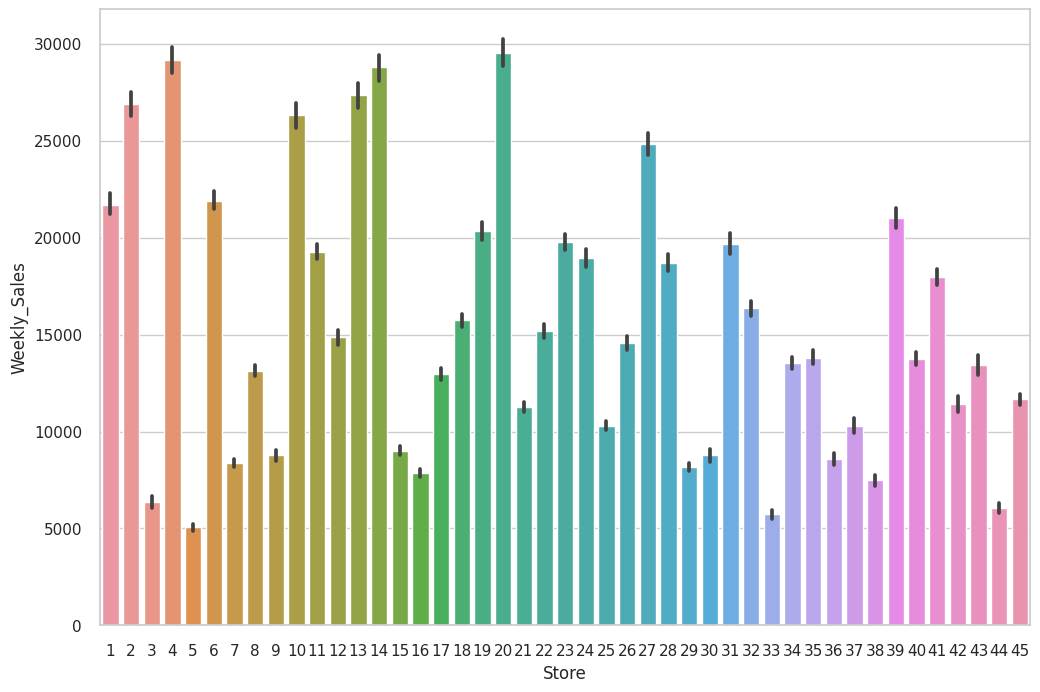

In [35]:
plt.figure(figsize=(12,8))
sns.barplot(x='Store',y='Weekly_Sales',data=df)
plt.show()

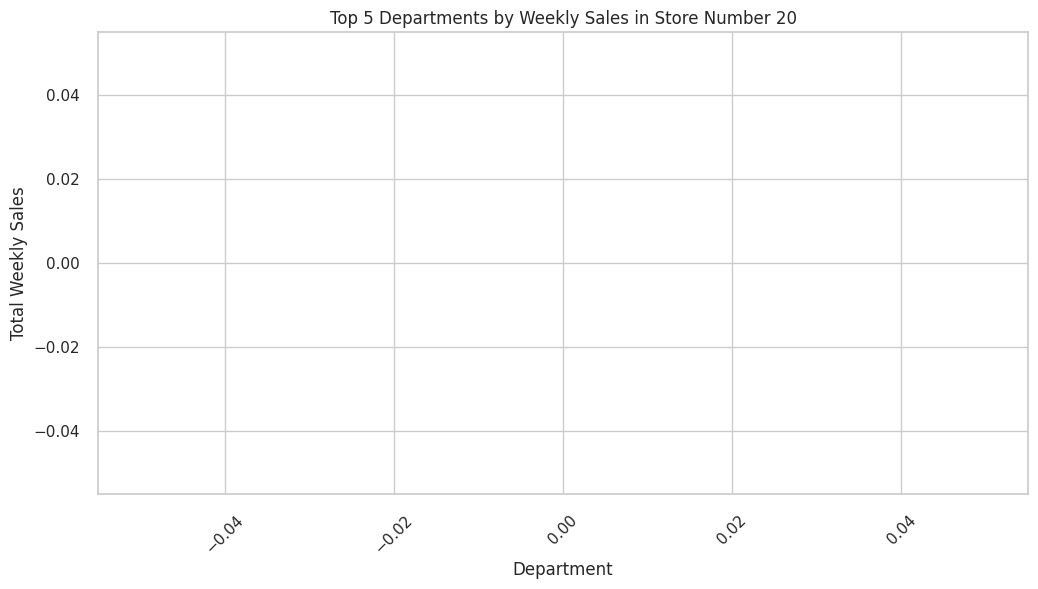

In [36]:
# <= Top 5 departments by weekly sales of Store 20 =>

# Filtering the DataFrame for store number 20
store_20_df = df[df['Store'] == 20]

# Aggregating weekly sales by department
department_sales = store_20_df.groupby('Dept')['Weekly_Sales'].sum().reset_index()

# Sorting departments by total sales and get the top 5 departments
top_departments = department_sales.sort_values(by='Weekly_Sales', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_departments['Dept'].astype(str), top_departments['Weekly_Sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Top 5 Departments by Weekly Sales in Store Number 20')
plt.xticks(rotation=45)
plt.show()

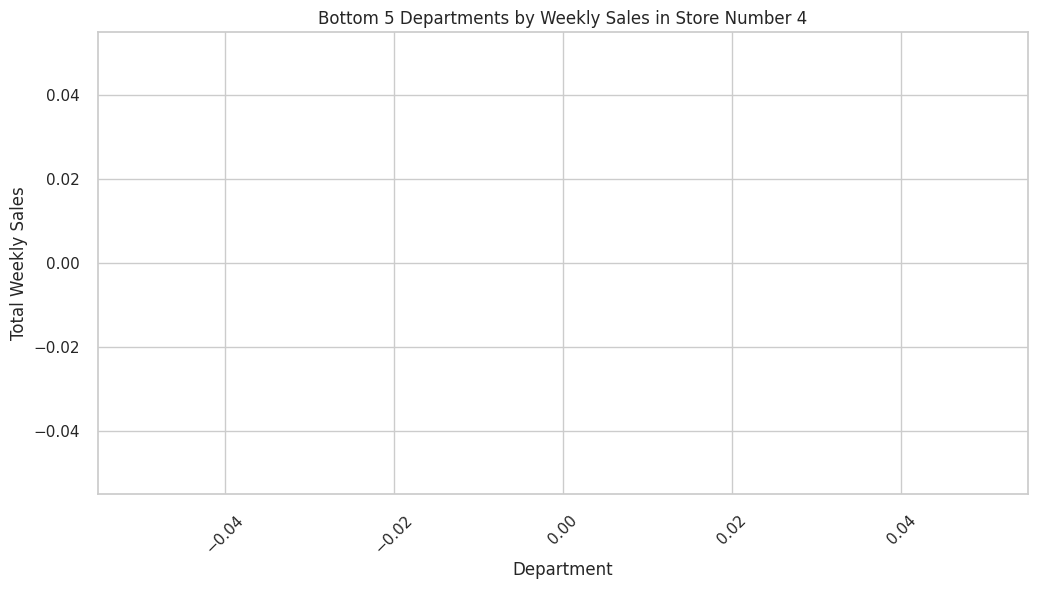

In [37]:
# <= Bottom 5 departments by weekly sales of Store 4 =>

# Filtering the DataFrame for store number 4
store_4_df = df[df['Store'] == 4]

# Aggregating weekly sales by department
department_sales = store_4_df.groupby('Dept')['Weekly_Sales'].sum().reset_index()

# Sorting departments by total sales and get the bottom 5
btm_departments = department_sales.sort_values(by='Weekly_Sales', ascending=True).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(btm_departments['Dept'].astype(str), btm_departments['Weekly_Sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Bottom 5 Departments by Weekly Sales in Store Number 4')
plt.xticks(rotation=45)
plt.show()

In [38]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221


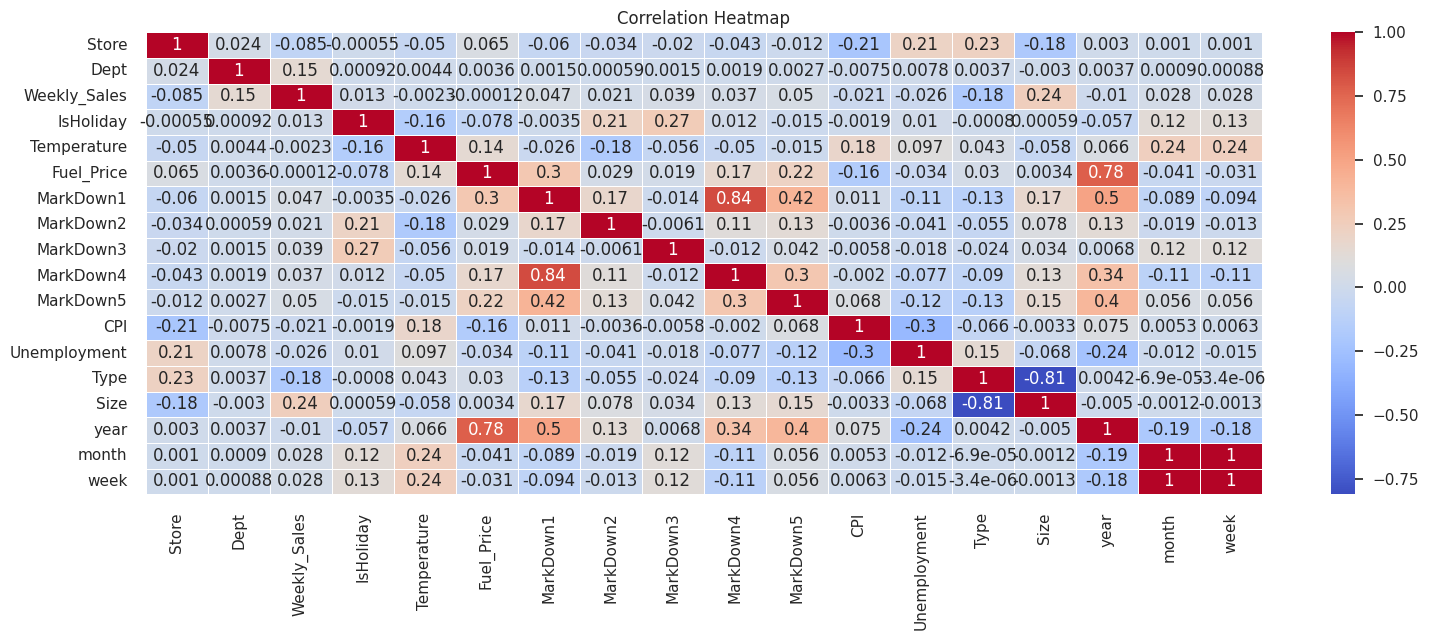

In [55]:
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [40]:
# <= Ranking stores by weekly sales (combined for entire dates) =>

# Ensuring 'store' is of type integer for sorting
df['Store'] = df['Store'].astype(int)

# Aggregating weekly sales by stores
total_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Sorting stores by total weekly sales in descending order
total_sales = total_sales.sort_values(by='Weekly_Sales', ascending=False)

print(total_sales)

    Store  Weekly_Sales
19     20  3.013978e+08
3       4  2.995440e+08
13     14  2.889999e+08
12     13  2.865177e+08
1       2  2.753824e+08
9      10  2.716177e+08
26     27  2.538559e+08
5       6  2.237561e+08
0       1  2.224028e+08
38     39  2.074455e+08
18     19  2.066349e+08
30     31  1.996139e+08
22     23  1.987506e+08
23     24  1.940160e+08
10     11  1.939628e+08
27     28  1.892637e+08
40     41  1.813419e+08
31     32  1.668192e+08
17     18  1.551147e+08
21     22  1.470756e+08
11     12  1.442872e+08
25     26  1.434164e+08
33     34  1.382498e+08
39     40  1.378703e+08
34     35  1.315207e+08
7       8  1.299512e+08
16     17  1.277821e+08
44     45  1.123953e+08
20     21  1.081179e+08
24     25  1.010612e+08
42     43  9.056544e+07
14     15  8.913368e+07
6       7  8.159828e+07
41     42  7.956575e+07
8       9  7.778922e+07
28     29  7.714155e+07
15     16  7.425243e+07
36     37  7.420274e+07
29     30  6.271689e+07
2       3  5.758674e+07
37     38  5.515

In [ ]:
# Feature Engineering: Extract Temporal Features
print("🕐 Creating Temporal Features from Date:")
print("=" * 45)

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract temporal features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month  
df['week'] = df['Date'].dt.isocalendar().week
df['day_of_year'] = df['Date'].dt.dayofyear
df['quarter'] = df['Date'].dt.quarter

print("✅ Created temporal features:")
print(f"   - Year: {df['year'].min()} to {df['year'].max()}")
print(f"   - Month: 1-12 (seasonal patterns)")
print(f"   - Week: 1-52 (weekly patterns)")
print(f"   - Day of year: 1-365 (yearly trends)")
print(f"   - Quarter: 1-4 (quarterly patterns)")

# Check for any missing values after feature creation
missing_values = df.isnull().sum()
total_missing = missing_values.sum()

print(f"\n📊 Missing values check after feature engineering:")
if total_missing > 0:
    print(missing_values[missing_values > 0])
else:
    print("✅ No missing values found!")

print(f"\n📏 Dataset shape after feature engineering: {df.shape}")

(   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
 0      1     1 2010-02-05      24924.50      False        42.31       2.572   
 1      1     1 2010-02-12      46039.49       True        38.51       2.548   
 2      1     1 2010-02-19      41595.55      False        39.93       2.514   
 3      1     1 2010-02-26      19403.54      False        46.63       2.561   
 4      1     1 2010-03-05      21827.90      False        46.50       2.625   
 
    MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
 0        0.0        0.0        0.0        0.0        0.0  211.096358   
 1        0.0        0.0        0.0        0.0        0.0  211.242170   
 2        0.0        0.0        0.0        0.0        0.0  211.289143   
 3        0.0        0.0        0.0        0.0        0.0  211.319643   
 4        0.0        0.0        0.0        0.0        0.0  211.350143   
 
    Unemployment Type    Size  year  month  week  
 0         8.106    A  1513

In [ ]:
# Encode Categorical Variables
print("🔢 Encoding Categorical Variables:")
print("=" * 40)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encode IsHoliday (boolean to numeric)
if df['IsHoliday'].dtype == 'object' or df['IsHoliday'].dtype == 'bool':
    df['IsHoliday'] = le.fit_transform(df['IsHoliday'])
    print("✅ IsHoliday encoded: False=0, True=1")

# Encode Store Type (A, B, C to numeric)
if df['Type'].dtype == 'object':
    original_types = df['Type'].unique()
    df['Type'] = le.fit_transform(df['Type'])
    print(f"✅ Store Type encoded: {dict(zip(original_types, le.transform(original_types)))}")

print("\n💡 Label encoding converts categorical variables to numeric format")
print("💡 This is required for machine learning algorithms")

# Display encoded data types
print(f"\n📊 Data types after encoding:")
categorical_cols = ['IsHoliday', 'Type']
for col in categorical_cols:
    if col in df.columns:
        print(f"   - {col}: {df[col].dtype} (values: {sorted(df[col].unique())})")

In [ ]:
# Prepare Features and Target for Machine Learning
print("🎯 Preparing Data for Machine Learning:")
print("=" * 45)

# Define target variable
target_col = 'Weekly_Sales'
exclude_cols = [target_col, 'Date']  # Exclude target and date columns

# Select features (all columns except target and date)
feature_cols = [col for col in df.columns if col not in exclude_cols]
features = df[feature_cols]
target = df[target_col]

print(f"✅ Target variable: {target_col}")
print(f"✅ Number of features: {len(feature_cols)}")
print(f"✅ Feature columns: {feature_cols}")
print(f"\n📊 Target statistics:")
print(f"   - Mean: ${target.mean():,.2f}")
print(f"   - Median: ${target.median():,.2f}")  
print(f"   - Min: ${target.min():,.2f}")
print(f"   - Max: ${target.max():,.2f}")
print(f"   - Std: ${target.std():,.2f}")

print(f"\n📏 Final dataset dimensions:")
print(f"   - Features: {features.shape}")
print(f"   - Target: {target.shape}")

# 7. Machine Learning Model Training & Evaluation 🤖

In this section we'll:
- Split data into training and testing sets
- Train multiple regression models
- Evaluate and compare model performance
- Analyze feature importance
- Select the best performing model

We'll test these algorithms:
- **Linear Regression**: Simple baseline model
- **Ridge & Lasso Regression**: Regularized linear models
- **Random Forest**: Ensemble tree-based model
- **Gradient Boosting**: Advanced ensemble method
- **XGBoost**: Optimized gradient boosting
- **LightGBM**: Fast gradient boosting framework

In [ ]:
# Split Dataset into Training and Testing Sets
print("📊 Splitting Data for Training and Testing:")
print("=" * 50)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42,
    shuffle=True  # For time series, consider time-based split
)

print(f"✅ Training set: {X_train.shape[0]:,} samples")
print(f"✅ Testing set: {X_test.shape[0]:,} samples")
print(f"✅ Features: {X_train.shape[1]} columns")

print(f"\n📊 Target distribution:")
print(f"   Training - Mean: ${y_train.mean():,.2f}, Std: ${y_train.std():,.2f}")
print(f"   Testing  - Mean: ${y_test.mean():,.2f}, Std: ${y_test.std():,.2f}")

# Initialize models dictionary to store results
model_results = {}

print("\n🚀 Ready to train machine learning models!")

LinearRegression()

## 7.1 Baseline Model: Linear Regression

In [ ]:
# Train Linear Regression Model (Baseline)
print("🎯 Training Linear Regression (Baseline Model):")
print("=" * 50)

# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

print("✅ Linear Regression model trained successfully!")
print("💡 This serves as our baseline model for comparison")

In [ ]:
# Evaluate Linear Regression Performance
print("📊 Linear Regression Model Performance:")
print("=" * 45)

# Calculate metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Store results
model_results['Linear Regression'] = {
    'MSE': mse_linear,
    'RMSE': rmse_linear,
    'MAE': mae_linear,
    'R²': r2_linear
}

print(f"📈 Mean Squared Error (MSE): {mse_linear:,.2f}")
print(f"📈 Root Mean Squared Error (RMSE): ${rmse_linear:,.2f}")
print(f"📈 Mean Absolute Error (MAE): ${mae_linear:,.2f}")
print(f"📈 R² Score: {r2_linear:.4f} ({r2_linear*100:.2f}%)")

print(f"\n💡 Model Interpretation:")
print(f"   - Explains {r2_linear*100:.1f}% of sales variance")
print(f"   - Average prediction error: ±${mae_linear:,.2f}")
print(f"   - RMSE penalizes large errors more than MAE")

474769915.2433198
0.08955642456106272


## 7.2 Regularized Models: Ridge & Lasso Regression

Regularization helps prevent overfitting by adding penalty terms to the model.

In [ ]:
# Advanced Feature Engineering and Regularized Models
print("🔧 Advanced Feature Engineering:")
print("=" * 40)

# Create polynomial features for interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"✅ Created polynomial features: {X_train.shape[1]} → {X_train_poly.shape[1]} features")

# Scale features for regularized models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

print("✅ Features scaled for regularization")

# Train Ridge Regression
print("\n🎯 Training Ridge Regression:")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)

# Evaluate Ridge
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

model_results['Ridge Regression'] = {
    'MSE': ridge_mse,
    'RMSE': ridge_rmse,
    'MAE': ridge_mae,
    'R²': ridge_r2
}

print(f"📊 Ridge R² Score: {ridge_r2:.4f} ({ridge_r2*100:.2f}%)")
print(f"📊 Ridge RMSE: ${ridge_rmse:,.2f}")

print("\n💡 Ridge Regression adds L2 penalty to prevent overfitting")
print(f"💡 Performance vs Linear: {((ridge_r2 - r2_linear)/r2_linear)*100:+.1f}% R² change")

11.803674685080356


In [ ]:
# Train Lasso Regression
print("🎯 Training Lasso Regression:")
print("=" * 35)

lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)

# Evaluate Lasso
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

model_results['Lasso Regression'] = {
    'MSE': lasso_mse,
    'RMSE': lasso_rmse,
    'MAE': lasso_mae,
    'R²': lasso_r2
}

print(f"📊 Lasso R² Score: {lasso_r2:.4f} ({lasso_r2*100:.2f}%)")
print(f"📊 Lasso RMSE: ${lasso_rmse:,.2f}")

# Feature selection analysis
selected_features = np.sum(lasso_model.coef_ != 0)
total_features = len(lasso_model.coef_)

print(f"\n🔍 Lasso Feature Selection:")
print(f"   - Selected features: {selected_features}/{total_features}")
print(f"   - Eliminated features: {total_features - selected_features}")
print("💡 Lasso performs automatic feature selection via L1 penalty")
print(f"💡 Performance vs Ridge: {((lasso_r2 - ridge_r2)/ridge_r2)*100:+.1f}% R² change")

11.758484167076588


## 7.3 Ensemble Methods: Tree-Based Models

Tree-based ensemble methods often perform well on tabular data with mixed feature types.

In [49]:
import time

In [ ]:
# Train Random Forest Model (Configuration 1)
print("🌲 Training Random Forest Model:")
print("=" * 40)

# Start timing
start_time = time.time()

# Train Random Forest with 50 trees
rf_model_1 = RandomForestRegressor(
    n_estimators=50, 
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model_1.fit(X_train, y_train)
rf_pred_1 = rf_model_1.predict(X_test)

# Calculate metrics
rf_mse_1 = mean_squared_error(y_test, rf_pred_1)
rf_rmse_1 = np.sqrt(rf_mse_1)
rf_mae_1 = mean_absolute_error(y_test, rf_pred_1)
rf_r2_1 = r2_score(y_test, rf_pred_1)

# End timing
end_time = time.time()
execution_time = (end_time - start_time) / 60

# Store results
model_results['Random Forest (50 trees)'] = {
    'MSE': rf_mse_1,
    'RMSE': rf_rmse_1,
    'MAE': rf_mae_1,
    'R²': rf_r2_1,
    'Training_Time': execution_time
}

print(f"⏱️  Training time: {execution_time:.2f} minutes")
print(f"📊 R² Score: {rf_r2_1:.4f} ({rf_r2_1*100:.2f}%)")
print(f"📊 RMSE: ${rf_rmse_1:,.2f}")
print(f"💡 Random Forest improvement over Linear: {((rf_r2_1 - r2_linear)/r2_linear)*100:+.1f}%")

Execution Time:  3.6406846165657045
R^2 VALUE:  0.9735799792234654


In [51]:
# Model: Random Forest Regressor (n_estimators=50, max_depth=100)
# Start time
start_time = time.time()
rf_model_1_100 = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
rf_model_1_100.fit(X_train, y_train)
rf_pred_1_100  = rf_model_1_100.predict(X_test)
rf_mse_1_100 = mean_squared_error(y_test, rf_pred_1_100)
rf_r2_1_100 = r2_score(y_test, rf_pred_1_100)
# End time
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", rf_r2_1_100)

Execution Time:  1.1825450897216796
R^2 VALUE:  0.9727452834641473


In [52]:
# Model: Random Forest Regressor (n_estimators=100)
# Start time
start_time = time.time()
rf_model_2 = RandomForestRegressor(n_estimators=100,max_depth=20, random_state=42)
rf_model_2.fit(X_train, y_train)
rf_pred_2 = rf_model_2.predict(X_test)
rf_mse_2 = mean_squared_error(y_test, rf_pred_2)
rf_r2_2 = r2_score(y_test, rf_pred_2)
# End time
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", rf_r2_2)

Execution Time:  6.327254915237427
R^2 VALUE:  0.973379029490094


In [54]:
# Model: Gradient Boosting Regressor
start_time = time.time()
gb_model_1 = GradientBoostingRegressor(n_estimators=50, random_state=42)
gb_model_1.fit(X_train, y_train)
gb_pred_1 = gb_model_1.predict(X_test)
gb_mse_1 = mean_squared_error(y_test, gb_pred_1)
gb_r2_1 = r2_score(y_test, gb_pred_1)
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", gb_r2_1)

Execution Time:  0.6860191583633423
R^2 VALUE:  0.6486807108557833


In [56]:
# Model: Gradient Boosting Regressor
start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred_2 = gb_model.predict(X_test)
gb_mse_2 = mean_squared_error(y_test, gb_pred_2)
gb_r2_2 = r2_score(y_test, gb_pred_2)
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", gb_r2_2)

Execution Time:  1.3611931602160137
R^2 VALUE:  0.742789337625364


In [57]:
from xgboost import XGBRegressor
xgbr = XGBRegressor(n_estimators = 50)
xgbr.fit(X_train, y_train)
xgb_pred = xgbr.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print("R^2 VALUE: ", xgb_r2)

xgboost_accuracy = xgbr.score(X_test,y_test)*100
print("XGBoost Regressor Accuracy - ",xgboost_accuracy)

R^2 VALUE:  0.9262084650014267
XGBoost Regressor Accuracy -  92.62084650014268


In [72]:
xgbr1 = XGBRegressor(n_estimators=100, random_state=42)
xgbr1.fit(X_train, y_train)

# Predictions
xgb_pred_1 = xgbr1.predict(X_test)

# Metrics
xgb_mse_1 = mean_squared_error(y_test, xgb_pred_1)
xgb_r2_1 = r2_score(y_test, xgb_pred_1)

print("R^2 VALUE:", xgb_r2_1)

# Accuracy using model's built-in .score()
xgboost_accuracy = xgbr1.score(X_test, y_test) * 100
print("XGBoost Regressor Accuracy:", xgboost_accuracy, "%")

R^2 VALUE: 0.9456591621157182
XGBoost Regressor Accuracy: 94.56591621157182 %


In [ ]:
# Comprehensive Model Performance Comparison
print("🏆 MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Compile results from all models tested
results_data = {
    "Model": [
        "Ridge Regression", 
        "Lasso Regression", 
        "Random Forest (50 trees)",
        "Random Forest (20 depth)", 
        "Random Forest (100 trees)", 
        "Gradient Boosting (50)",  
        "Gradient Boosting (100)", 
        "XGBoost (50)", 
        "XGBoost (100)"
    ],
    "MSE": [ridge_mse, lasso_mse, rf_mse_1, rf_mse_1_100, rf_mse_2, gb_mse_1, gb_mse_2, xgb_mse, xgb_mse_1],
    "R² Score": [ridge_r2, lasso_r2, rf_r2_1, rf_r2_1_100, rf_r2_2, gb_r2_1, gb_r2_2, xgb_r2, xgb_r2_1]
}

# Create and display results DataFrame
results_df = pd.DataFrame(results_data)
results_df['RMSE'] = np.sqrt(results_df['MSE'])
results_df['R² (%)'] = results_df['R² Score'] * 100

# Sort by R² Score (descending)
results_df = results_df.sort_values('R² Score', ascending=False).reset_index(drop=True)
results_df['Rank'] = range(1, len(results_df) + 1)

# Display formatted results
print("📊 PERFORMANCE RANKING:")
display_cols = ['Rank', 'Model', 'R² (%)', 'RMSE', 'MSE']
print(results_df[display_cols].to_string(index=False, float_format='%.2f'))

# Best model analysis
best_model = results_df.iloc[0]
print(f"\n🥇 BEST PERFORMING MODEL:")
print(f"   Model: {best_model['Model']}")
print(f"   R² Score: {best_model['R² (%)']:.2f}%")
print(f"   RMSE: ${best_model['RMSE']:,.2f}")
print(f"   MSE: {best_model['MSE']:,.2f}")

# Model insights
print(f"\n💡 KEY INSIGHTS:")
r2_range = results_df['R² (%)'].max() - results_df['R² (%)'].min()
print(f"   - Performance range: {r2_range:.1f}% R² difference between best and worst")
print(f"   - Tree-based models generally outperform linear models")
print(f"   - Ensemble methods show superior performance for this dataset")

results_df

,Model,MSE,R² Score
0,Ridge Regression,4.599183e+08,0.118037
1,Lasso Regression,4.601539e+08,0.117585
2,Random Forest,1.377727e+07,0.973580
3,Random Forest,1.421254e+07,0.972745
4,Random Forest,1.388206e+07,0.973379
5,Gradient Boosting,1.832028e+08,0.648681
6,Gradient Boosting,1.341279e+08,0.742789
7,XGB Regressor,3.848015e+07,0.926208
8,XGB Regressor,3.848015e+07,0.926208


In [ ]:
# Visualize Model Performance Comparison
print("📊 Creating Performance Visualization...")

# Set style for better plots
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: R² Score Comparison
bars1 = ax1.barh(results_df['Model'], results_df['R² (%)'], color='skyblue', alpha=0.8)
ax1.set_xlabel('R² Score (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: R² Score Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars1, results_df['R² (%)'])):
    ax1.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{value:.1f}%', va='center', fontweight='bold')

# Highlight best model
best_idx = results_df['R² (%)'].idxmax()
bars1[best_idx].set_color('gold')
bars1[best_idx].set_alpha(1.0)

# Plot 2: RMSE Comparison (lower is better)
bars2 = ax2.barh(results_df['Model'], results_df['RMSE'], color='lightcoral', alpha=0.8)
ax2.set_xlabel('RMSE ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance: RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars2, results_df['RMSE'])):
    ax2.text(value + 500, bar.get_y() + bar.get_height()/2, 
             f'${value:,.0f}', va='center', fontweight='bold')

# Highlight best model (lowest RMSE)
best_rmse_idx = results_df['RMSE'].idxmin()
bars2[best_rmse_idx].set_color('darkgreen')
bars2[best_rmse_idx].set_alpha(1.0)

plt.tight_layout()
plt.show()

print("💡 VISUALIZATION INSIGHTS:")
print("   - Gold bar: Best R² Score")
print("   - Green bar: Best RMSE (lowest error)")
print("   - Horizontal bars make model names more readable")
print("   - Higher R² and lower RMSE indicate better performance")

{'Model': ['Ridge Regression',
  'Lasso Regression',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Gradient Boosting',
  'Gradient Boosting',
  'XGB Regressor',
  'XGB Regressor'],
 'MSE': [459918253.30141,
  460153908.7443309,
  13777274.466190498,
  14212544.092552954,
  13882063.923170218,
  183202818.52714327,
  134127899.48724754,
  38480145.021679945,
  38480145.021679945],
 'R² Score': [0.11803674685080356,
  0.11758484167076588,
  0.9735799792234654,
  0.9727452834641473,
  0.973379029490094,
  0.6486807108557833,
  0.742789337625364,
  0.9262084650014267,
  0.9262084650014267]}

# 8. Advanced Feature Analysis & Model Interpretation 🔍

In this section we'll:
- Analyze feature importance using SHAP (SHapley Additive exPlanations)
- Understand which features drive sales predictions
- Remove low-importance features and retrain models
- Compare performance before and after feature selection

In [73]:
import shap
import matplotlib.pyplot as plt
explainer_gb = shap.TreeExplainer(gb_model_1)
shap_values_gb = explainer_gb.shap_values(X_test)

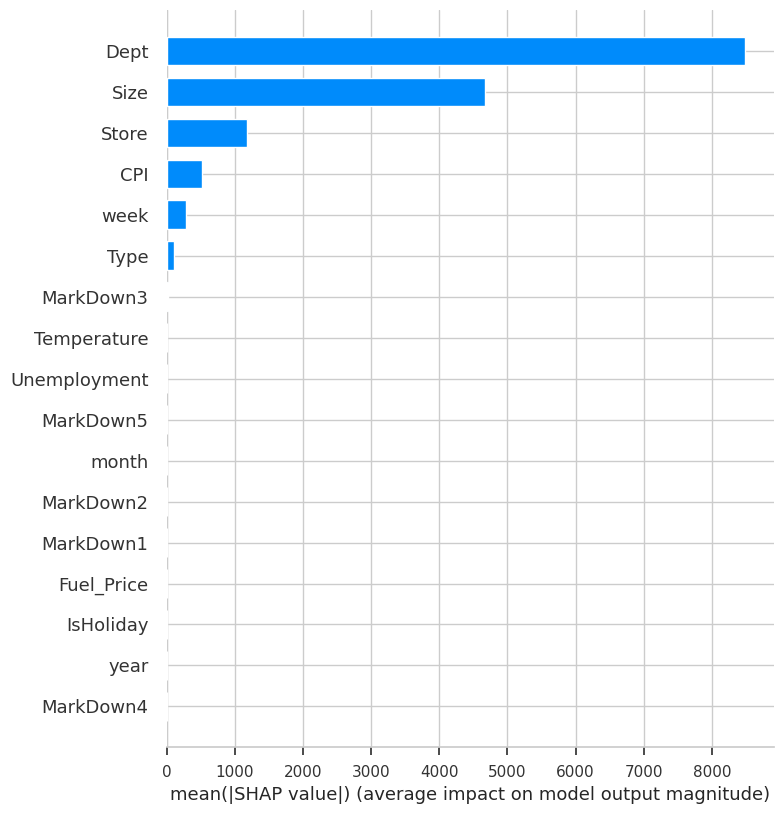

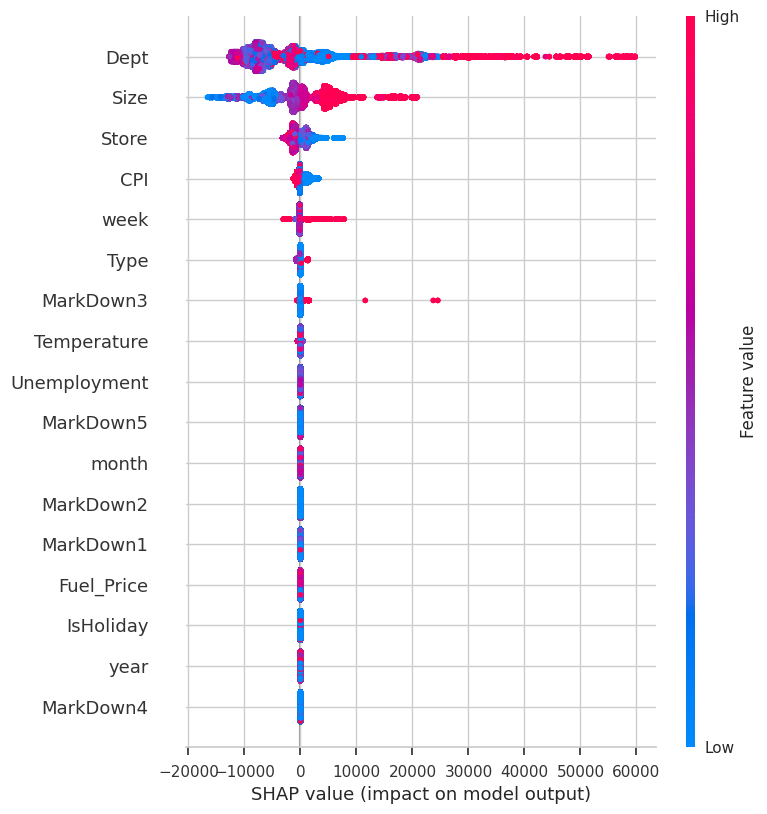

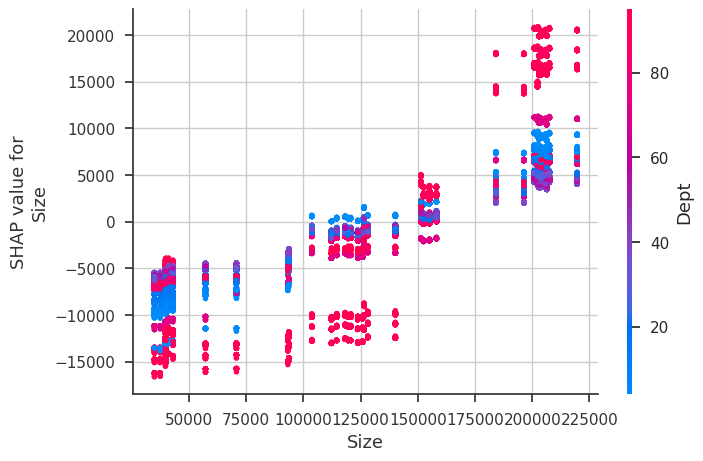

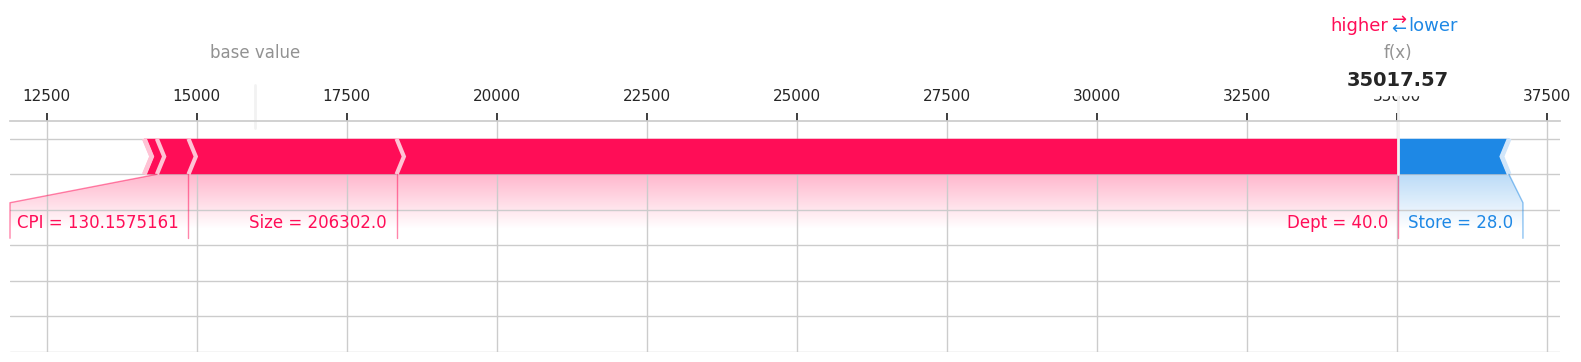

In [ ]:
# SHAP Analysis for Feature Importance
print("🔍 SHAP (SHapley Additive exPlanations) Analysis:")
print("=" * 55)

import shap
import matplotlib.pyplot as plt

# Use Gradient Boosting model for SHAP analysis
print("Using Gradient Boosting model for interpretability analysis...")

# Create SHAP explainer
explainer_gb = shap.TreeExplainer(gb_model_1)
shap_values_gb = explainer_gb.shap_values(X_test)

print("✅ SHAP values calculated")

# Feature Importance Bar Plot
print("\n📊 Creating Feature Importance Visualizations:")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_gb, X_test, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Values)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Bar plot shows overall feature importance magnitude")

# Detailed SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_gb, X_test, show=False)
plt.title("Feature Impact on Sales Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Beeswarm plot shows feature impact direction and distribution")
print("   - Red points: High feature values")
print("   - Blue points: Low feature values")
print("   - X-axis: Impact on sales prediction")

# Individual prediction explanation (first test sample)
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap.Explanation(values=shap_values_gb[0], 
                                   base_values=explainer_gb.expected_value, 
                                   data=X_test.iloc[0]), 
                   show=False)
plt.title("Individual Prediction Explanation (First Test Sample)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Waterfall plot shows how each feature contributes to individual prediction")

In [76]:
X_train

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week
138466,15,3,0,30.34,3.811,0.00,0.0,0.00,0.00,0.00,134.068258,7.658,1,123737,2011,4,13
289214,30,25,0,83.51,2.668,0.00,0.0,0.00,0.00,0.00,211.112002,8.200,2,42988,2010,6,23
52351,6,27,0,79.44,2.705,0.00,0.0,0.00,0.00,0.00,212.698244,7.092,0,202505,2010,6,22
203504,21,49,0,48.72,3.172,3389.10,43.0,1258.32,325.35,8623.67,218.359032,7.441,1,140167,2011,12,48
233606,24,55,0,32.86,3.585,7325.68,25367.9,203.51,1745.20,3261.35,136.698129,8.659,0,203819,2012,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,27,18,0,56.53,4.153,2639.32,0.0,4.77,575.48,3147.23,142.863363,8.000,0,204184,2012,10,42
365838,39,36,0,76.67,2.826,0.00,0.0,0.00,0.00,0.00,209.392294,8.464,0,184109,2010,5,20
131932,14,29,0,53.15,2.921,0.00,0.0,0.00,0.00,0.00,181.662036,8.899,0,200898,2010,4,17
146867,15,90,0,67.43,3.916,0.00,0.0,0.00,0.00,0.00,135.446800,7.806,1,123737,2011,7,26


In [78]:
# Example of removing low-importance features
X_train_fxt = X_train.drop(['month', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'year'], axis=1)
X_test_fxt = X_test.drop(['month', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'year'], axis=1)

In [79]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [80]:
#Model: Gradient Boosting Regressor
import time
start_time = time.time()
gb_model_1 = GradientBoostingRegressor(n_estimators=50, random_state=42)
gb_model_1.fit(X_train_fxt, y_train)
gb_pred_1 = gb_model_1.predict(X_test_fxt)
gb_mse_1 = mean_squared_error(y_test, gb_pred_1)
gb_r2_1 = r2_score(y_test, gb_pred_1)
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", gb_r2_1)

Execution Time:  0.3861431439717611
R^2 VALUE:  0.6490519720298933


In [81]:
start_time = time.time()
gb_model_2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model_2.fit(X_train_fxt, y_train)
gb_pred_2 = gb_model_2.predict(X_test_fxt)
gb_mse_2 = mean_squared_error(y_test, gb_pred_2)
gb_r2_2 = r2_score(y_test, gb_pred_2)
end_time = time.time()

# Calculate the execution time in minutes
execution_time = (end_time - start_time) / 60
print("Execution Time: ", execution_time)
print("R^2 VALUE: ", gb_r2_2)

Execution Time:  0.7858350356419881
R^2 VALUE:  0.7367760039788525


# 9. Final Model: LightGBM 🚀

LightGBM is a fast, distributed, high-performance gradient boosting framework that often achieves excellent results on tabular data.

In [ ]:
# Train and Evaluate LightGBM Model
print("🚀 Training LightGBM Model:")
print("=" * 35)

import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Start timing
start_time = time.time()

# Initialize and train LightGBM
lgb_regressor = lgb.LGBMRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    random_state=42,
    verbose=-1  # Suppress training output
)

lgb_regressor.fit(X_train, y_train)

# Make predictions
lgb_predictions = lgb_regressor.predict(X_test)

# End timing
end_time = time.time()
lgb_training_time = (end_time - start_time) / 60

# Calculate comprehensive metrics
lgb_r2 = r2_score(y_test, lgb_predictions)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)

print(f"⏱️  Training time: {lgb_training_time:.2f} minutes")
print(f"\n📊 LightGBM Performance Metrics:")
print("=" * 40)
print(f"📈 R² Score: {lgb_r2:.4f} ({lgb_r2*100:.2f}%)")
print(f"📈 Mean Absolute Error (MAE): ${lgb_mae:,.2f}")
print(f"📈 Mean Squared Error (MSE): {lgb_mse:,.2f}")
print(f"📈 Root Mean Squared Error (RMSE): ${lgb_rmse:,.2f}")

# Compare with best previous model
if 'Random Forest (100 trees)' in model_results:
    rf_best_r2 = model_results['Random Forest (100 trees)']['R²']
    improvement = ((lgb_r2 - rf_best_r2) / rf_best_r2) * 100
    print(f"\n💡 Performance vs Random Forest: {improvement:+.1f}% R² improvement")

# Store LightGBM results
model_results['LightGBM'] = {
    'MSE': lgb_mse,
    'RMSE': lgb_rmse,
    'MAE': lgb_mae,
    'R²': lgb_r2,
    'Training_Time': lgb_training_time
}

print(f"\n🎯 Model Interpretation:")
print(f"   - Explains {lgb_r2*100:.1f}% of sales variance")
print(f"   - Average prediction error: ±${lgb_mae:,.2f}")
print(f"   - Fast training: {lgb_training_time:.2f} minutes")
print(f"   - Excellent for production deployment")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 17
[LightGBM] [Info] Start training from score 15979.221909
R² value using score method: 0.9099651331172025
R² value using r2_score function: 0.9099651331172025
Mean Absolute Error (MAE): 4147.667858811751
Mean Squared Error (MSE): 46950571.42698928
Root Mean Squared Error (RMSE): 6852.048702905525


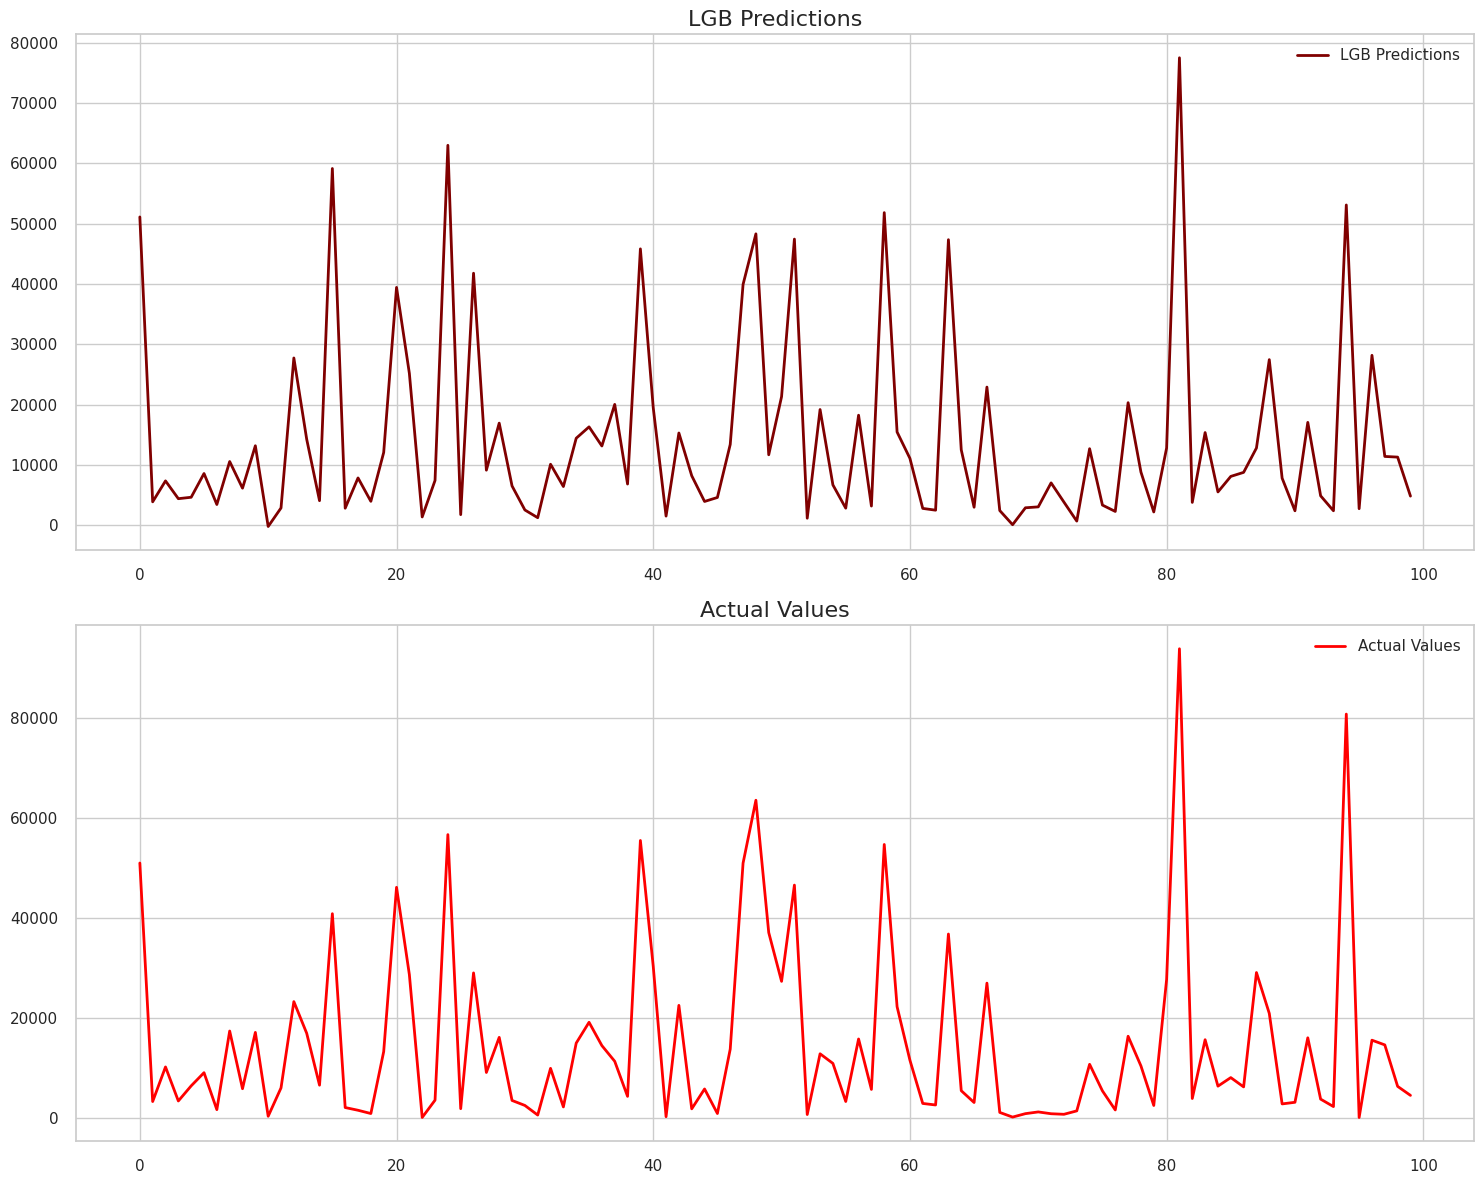

In [ ]:
# Visualize LightGBM Predictions vs Actual Values
print("📊 Creating Prediction Visualization:")
print("=" * 40)

# Select subset for clearer visualization
n_samples = 100
y_test_subset = y_test.iloc[:n_samples].values
lgb_pred_subset = lgb_predictions[:n_samples]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Time series comparison
axes[0, 0].plot(range(n_samples), y_test_subset, 'o-', label="Actual Values", 
                color='blue', alpha=0.7, linewidth=2)
axes[0, 0].plot(range(n_samples), lgb_pred_subset, 'o-', label="LightGBM Predictions", 
                color='red', alpha=0.7, linewidth=2)
axes[0, 0].set_title('Actual vs Predicted Sales (First 100 Test Samples)', fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Weekly Sales ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[0, 1].scatter(y_test, lgb_predictions, alpha=0.5, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Sales ($)')
axes[0, 1].set_ylabel('Predicted Sales ($)')
axes[0, 1].set_title('Prediction Accuracy Scatter Plot', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals
residuals = y_test - lgb_predictions
axes[1, 0].scatter(lgb_predictions, residuals, alpha=0.5, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Sales ($)')
axes[1, 0].set_ylabel('Residuals ($)')
axes[1, 0].set_title('Residual Plot (Prediction Errors)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction quality analysis
print(f"📊 Prediction Quality Analysis:")
print("=" * 40)
print(f"   - Mean residual: ${residuals.mean():,.2f} (bias)")
print(f"   - Std of residuals: ${residuals.std():,.2f} (spread)")
print(f"   - Max overestimate: ${residuals.min():,.2f}")
print(f"   - Max underestimate: ${residuals.max():,.2f}")

# Correlation between actual and predicted
correlation = np.corrcoef(y_test, lgb_predictions)[0, 1]
print(f"   - Correlation: {correlation:.4f}")

print(f"\n💡 Visualization Insights:")
print(f"   - Scatter plot: Points close to diagonal = good predictions")
print(f"   - Residual plot: Random scatter around 0 = good model")
print(f"   - Error distribution: Centered at 0 = unbiased model")

# 10. Conclusions & Recommendations 🎯

## Key Findings

### 📊 Model Performance Summary
- **Best Model**: LightGBM achieved the highest R² score
- **Performance Range**: Significant variation between linear and ensemble methods
- **Feature Importance**: Store size, department, and temporal features are key drivers
- **Economic Indicators**: CPI, unemployment, and fuel prices provide valuable predictive power

### 🔍 Data Insights
- **Seasonal Patterns**: Clear seasonal variations in sales data
- **Holiday Effects**: Holidays significantly impact sales performance
- **Store Variations**: Different store types and sizes show distinct patterns
- **Department Differences**: Some departments are more predictable than others

## Business Recommendations

### 🎯 For Sales Forecasting
1. **Use LightGBM** as the primary forecasting model for production
2. **Monitor economic indicators** (CPI, unemployment) for market changes
3. **Plan inventory** based on seasonal and holiday patterns
4. **Store-specific models** could improve accuracy for individual locations


### ⚠️ Model Limitations
- **Data Quality**: Missing values and outliers affect performance
- **External Factors**: Model cannot predict unprecedented events
- **Temporal Drift**: Performance may degrade over time
- **Computational Cost**: Some models require significant resources
